In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3 #canales RGB
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Hoja",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7182 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Mancha_angular_hoja', 'Mancha_hoja', 'Oidio', 'Quemadura_hoja', 'Saludable']

In [5]:
len(dataset)

449

In [6]:
225*32

7200

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    '''(# de imagenes,256*256,canales RGB)
    [0=Mancha_angular_hoja,1=Mancha_hoja,2=Oidio,3=Quemadura_hoja,4=Saludable] = label_batch '''

(16, 256, 256, 3)
[1 4 3 4 3 4 4 4 4 3 4 4 3 0 1 3]


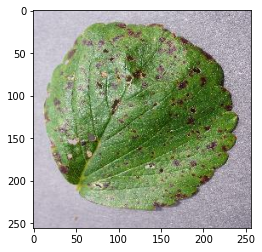

In [8]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

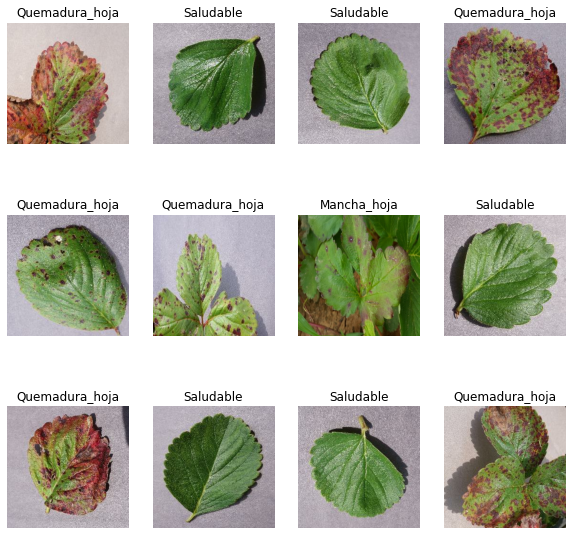

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off") 

In [10]:
len(dataset)

449

In [11]:
#80% ==> training
train_size = 0.8
len(dataset)*train_size

359.20000000000005

In [12]:
train_ds = dataset.take(180)
len(train_ds)

180

In [13]:
test_ds = dataset.skip(180)
len(test_ds)

269

In [14]:
#10% ==> validation 
val_size=0.1
len(dataset)*val_size

44.900000000000006

In [15]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [16]:
#10% ==> test
test_ds = test_ds.skip(22)
len(test_ds)

247

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

359

In [20]:
len(val_ds)

44

In [21]:
len(test_ds)

46

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3)),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
359/359 [==============================] - 283s 756ms/step - loss: 0.5077 - accuracy: 0.8603 - val_loss: 0.1564 - val_accuracy: 0.9446
Epoch 2/50
359/359 [==============================] - 266s 740ms/step - loss: 0.2470 - accuracy: 0.9159 - val_loss: 0.1639 - val_accuracy: 0.9403
Epoch 3/50
359/359 [==============================] - 260s 724ms/step - loss: 0.2457 - accuracy: 0.9175 - val_loss: 0.2141 - val_accuracy: 0.9261
Epoch 4/50
359/359 [==============================] - 265s 738ms/step - loss: 0.2205 - accuracy: 0.9262 - val_loss: 0.1437 - val_accuracy: 0.9474
Epoch 5/50
359/359 [==============================] - 266s 740ms/step - loss: 0.1907 - accuracy: 0.9383 - val_loss: 0.1701 - val_accuracy: 0.9474
Epoch 6/50
359/359 [==============================] - 270s 753ms/step - loss: 0.1830 - accuracy: 0.9385 - val_loss: 0.0962 - val_accuracy: 0.9588
Epoch 7/50
359/359 [==============================] - 263s 732ms/step - loss: 0.1265 - accuracy: 0.9580 - val_loss: 0.0619 -

In [30]:
scores = model.evaluate(test_ds)

46/46 [==============================] - 23s 247ms/step - loss: 1.1602 - accuracy: 0.4348


In [31]:
scores

[1.160199761390686, 0.43478259444236755]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 359}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5]

[0.507746696472168,
 0.24703344702720642,
 0.24566923081874847,
 0.22051145136356354,
 0.19072842597961426]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

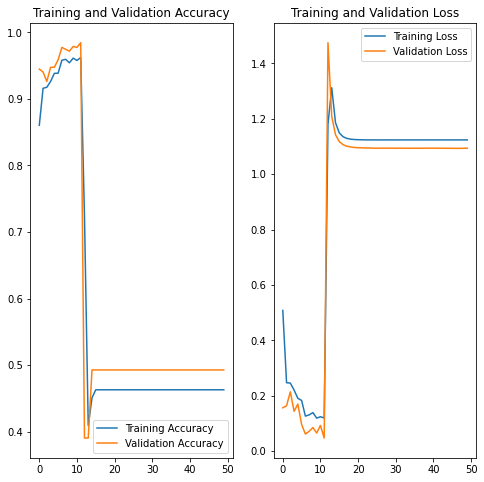

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Quemadura_hoja
1/1 [==============================] - 1s 722ms/step
predicted label: Quemadura_hoja


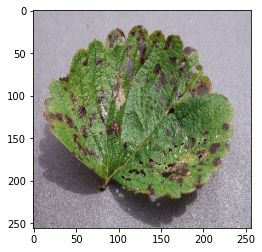

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


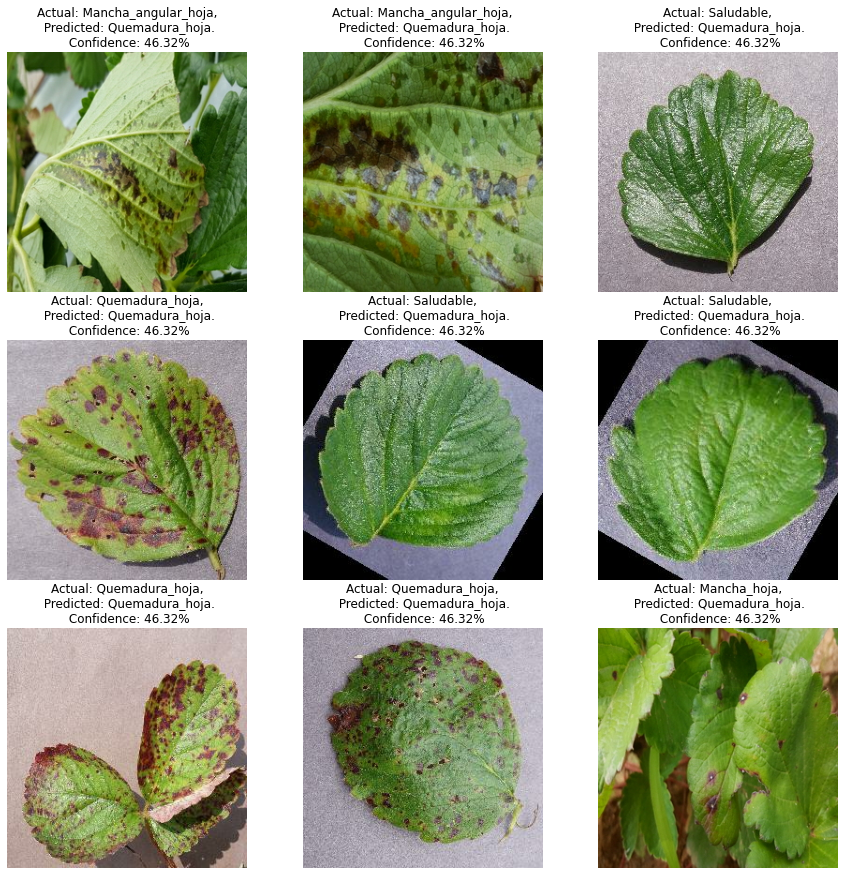

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
'''import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")'''

'import os\nmodel_version=max([int(i) for i in os.listdir("../models") + [0]])+1\nmodel.save(f"../models/{model_version}")'

In [44]:
'''[int(i) for i in os.listdir("../models")]'''

'[int(i) for i in os.listdir("../models")]'

In [45]:
'''model.save("../strawberry.h5")'''

'model.save("../strawberry.h5")'